<h1><center>Travel Insurance - Predictive Model</center></h1>
<center>July 2024</center>
<center>Celine Ng</center>

# Table of Contents

1. Project Introduction   
    1. Libraries Installation
    1. Dataset
    1. Data Cleaning
1. EDA
    1. Distribution
        1. Numeric Data
        2. Categorical Data
        3. Label
            1. Summary
    1. Correlation
        1. Correlation with numerical features
        1. Multicollinearity - Variance Inflation Factor
    1. Statistic Inference
        1. Target Population
        2. Transform 'AnnualIncome'
        3. Hypothesis Testing
1. Preprocessing
    1. Transformations
    1. Data Splitting
1. Models
    1. Apply various models
    1. Ensemble - Voting
1. Improvements

# 1. Project Introduction

**Goal:** <br>
The goal of the project is to build a model to predict if the customer will 
be <br> interested in buying travel insurance package based on the features 
<br>
given. 

## 1. Libraries Installation

In [1]:
%%capture
%pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_selector as selector
from statsmodels.stats.outliers_influence import variance_inflation_factor
from utils.statistics import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

## 2. Dataset

The dataset was downloaded from Kaggle, <br>[Travel Insurance Prediction Data](https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data)
<br>
on 23rd July 2024. The data comes from a Tour&Travel company. The company <br>
is offering travel insurance packages and requires to know which customers 
<br> would be interested based on its database history. The insurance was <br>
offered to some of the customers in 2019, the given data has been extracted 
<br>
during that period. The data is provided for almost 2000 of its previous <br>
customers. <br>

In [3]:
travelinsurance = pd.read_csv('datasets/TravelInsurancePrediction.csv')
travelinsurance.head()

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [4]:
travelinsurance = travelinsurance.drop(columns=['Unnamed: 0'])

1. How big is the dataset?

In [5]:
travelinsurance.shape

(1987, 9)

2. Data types

In [6]:
travelinsurance.dtypes

Age                     int64
Employment Type        object
GraduateOrNot          object
AnnualIncome            int64
FamilyMembers           int64
ChronicDiseases         int64
FrequentFlyer          object
EverTravelledAbroad    object
TravelInsurance         int64
dtype: object

Features: <br>
1. Age- Age Of The Customer <br>
2. Employment Type- The Sector In Which Customer Is Employed <br>
3. GraduateOrNot- Whether The Customer Is College Graduate Or Not <br>
4. AnnualIncome- The Yearly Income Of The Customer In Indian Rupees[Rounded 
To
 Nearest 50 Thousand Rupees] <br>
5. FamilyMembers- Number Of Members In Customer's Family <br>
6. ChronicDisease- Whether The Customer Suffers From Any Major Disease Or <br>
Conditions Like Diabetes/High BP or Asthama,etc.
7. FrequentFlyer- Derived Data Based On Customer's History Of Booking Air <br>
Tickets On Atleast 4 Different Instances In The Last 2 Years[2017-2019] <br>
9. EverTravelledAbroad- Has The Customer Ever Travelled To A Foreign <br>
Country[Not Necessarily Using The Company's Services]
<br>

Label: <br>
TravelInsurance- Did The Customer Buy Travel Insurance Package During <br>
Introductory Offering Held In The Year 2019.

3. Correct data types to match throughout the dataset

In [7]:
for col in ['ChronicDiseases', 'TravelInsurance']:
    travelinsurance[col] = travelinsurance[col].replace(0, 'No')
    travelinsurance[col] = travelinsurance[col].replace(1, 'Yes')
    
travelinsurance.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,Yes,No,No,No
1,31,Private Sector/Self Employed,Yes,1250000,7,No,No,No,No
2,34,Private Sector/Self Employed,Yes,500000,4,Yes,No,No,Yes
3,28,Private Sector/Self Employed,Yes,700000,3,Yes,No,No,No
4,28,Private Sector/Self Employed,Yes,700000,8,Yes,Yes,No,No


In [8]:
travelinsurance.dtypes

Age                     int64
Employment Type        object
GraduateOrNot          object
AnnualIncome            int64
FamilyMembers           int64
ChronicDiseases        object
FrequentFlyer          object
EverTravelledAbroad    object
TravelInsurance        object
dtype: object

## 3. Data Cleaning

1. Duplicated rows?

In [9]:
travelinsurance.duplicated().any()

np.True_

In [10]:
travelinsurance[travelinsurance.duplicated()].count()

Age                    738
Employment Type        738
GraduateOrNot          738
AnnualIncome           738
FamilyMembers          738
ChronicDiseases        738
FrequentFlyer          738
EverTravelledAbroad    738
TravelInsurance        738
dtype: int64

There are duplicates, but there is not enough context to decide whether they
 <br>
are the same customer or simply a coincidence that their personal 
information <br>
 are similar. I will leave this as it is for the purpose of the project.

2. Missing values?

In [11]:
travelinsurance.isna().any().any()

np.False_

3. Separate data and target 

In [12]:
target_name = 'TravelInsurance'
data, target = (travelinsurance.drop(columns=[target_name]), 
                travelinsurance[target_name])

4. Identify numerical and categorical columns

In [13]:
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

In [14]:
numerical_columns_selector = selector(dtype_include='int64')
numerical_columns = numerical_columns_selector(data)

# 2. EDA

## 1. Distribution

Objective:
1. Understand visually the distribution and outliers of our features and the
 <br>
label. 
2. Include mean(red) and median(blue) in the graphs to showcase the 
influence <br> of outliers, skewness in each case.

### 1. Numerical Data

In [15]:
travelinsurance[numerical_columns].describe()

,Age,AnnualIncome,FamilyMembers
count,1987.000000,1.987000e+03,1987.000000
mean,29.650226,9.327630e+05,4.752894
std,2.913308,3.768557e+05,1.609650
min,25.000000,3.000000e+05,2.000000
25%,28.000000,6.000000e+05,4.000000
50%,29.000000,9.000000e+05,5.000000
75%,32.000000,1.250000e+06,6.000000
max,35.000000,1.800000e+06,9.000000


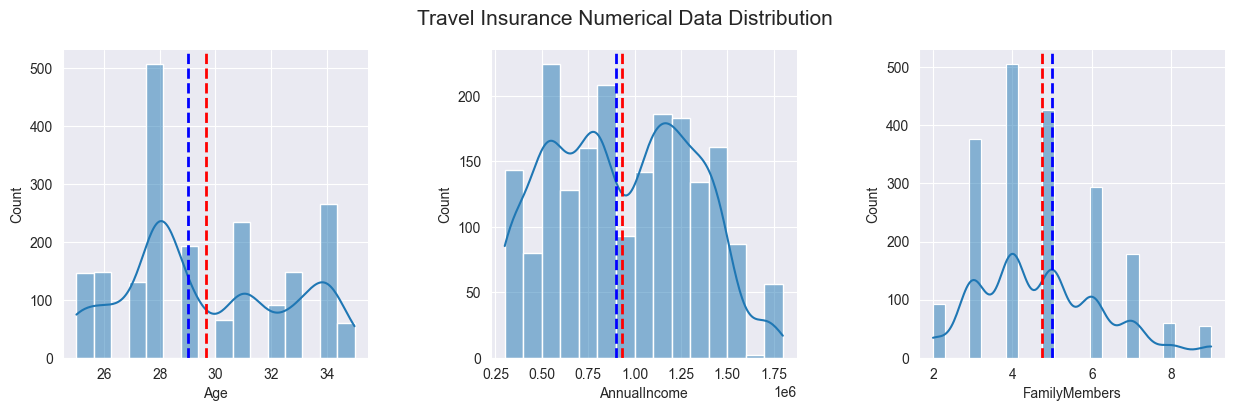

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
fig.subplots_adjust(hspace=0.3, wspace=0.4)

axes_flatten = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.histplot(x=col, data=travelinsurance, kde=True, ax=axes_flatten[i])
    mean_value = travelinsurance[col].mean()
    axes_flatten[i].axvline(mean_value, color='r', linestyle='--', linewidth=2)
    median_value = travelinsurance[col].median()
    axes_flatten[i].axvline(median_value, color='b', linestyle='--', 
                                linewidth=2)
    sns.despine(top=True, right=True, left=False, bottom=False)
    
fig.suptitle('Travel Insurance Numerical Data Distribution', fontsize=15)

plt.show()

There is not a clear distribution shape for Age.<br> 
Annual Income does seem to have a bimodal distribution, the lower income and
 <br>higher income. <br>
The number of Family Members is only more normally distributed one, with an 
<br>
average of 5 members.

Visualize outliers with boxplot

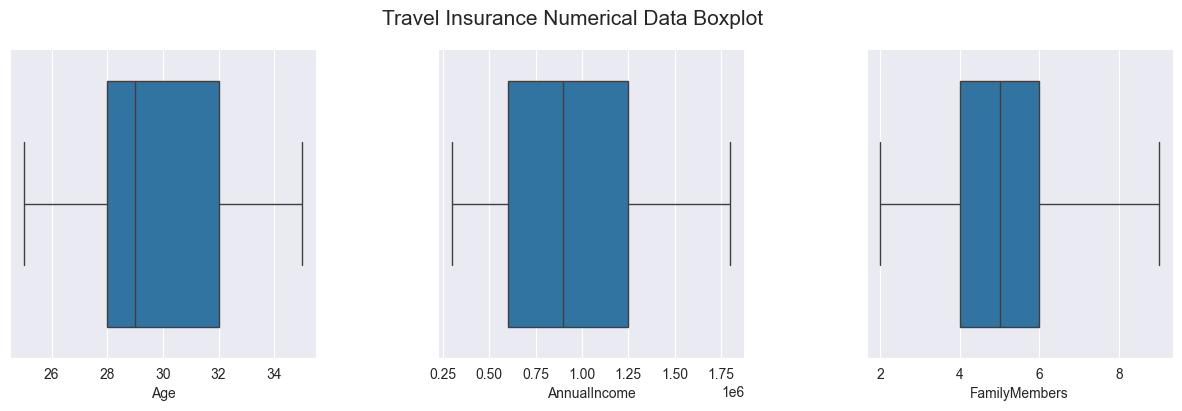

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
fig.subplots_adjust(hspace=0.3, wspace=0.4)

axes_flatten = axes.flatten()

for i, col in enumerate(numerical_columns):
        sns.boxplot(x=col, data=travelinsurance, ax=axes_flatten[i])
        sns.despine(top=True, right=True, left=False, bottom=False)
    
fig.suptitle('Travel Insurance Numerical Data Boxplot', fontsize=15)

plt.show()

Mean and median do not differ a lot, and this is reflected in boxplot <br>
representations, as there is no outliers.

### 2. Categorical Data

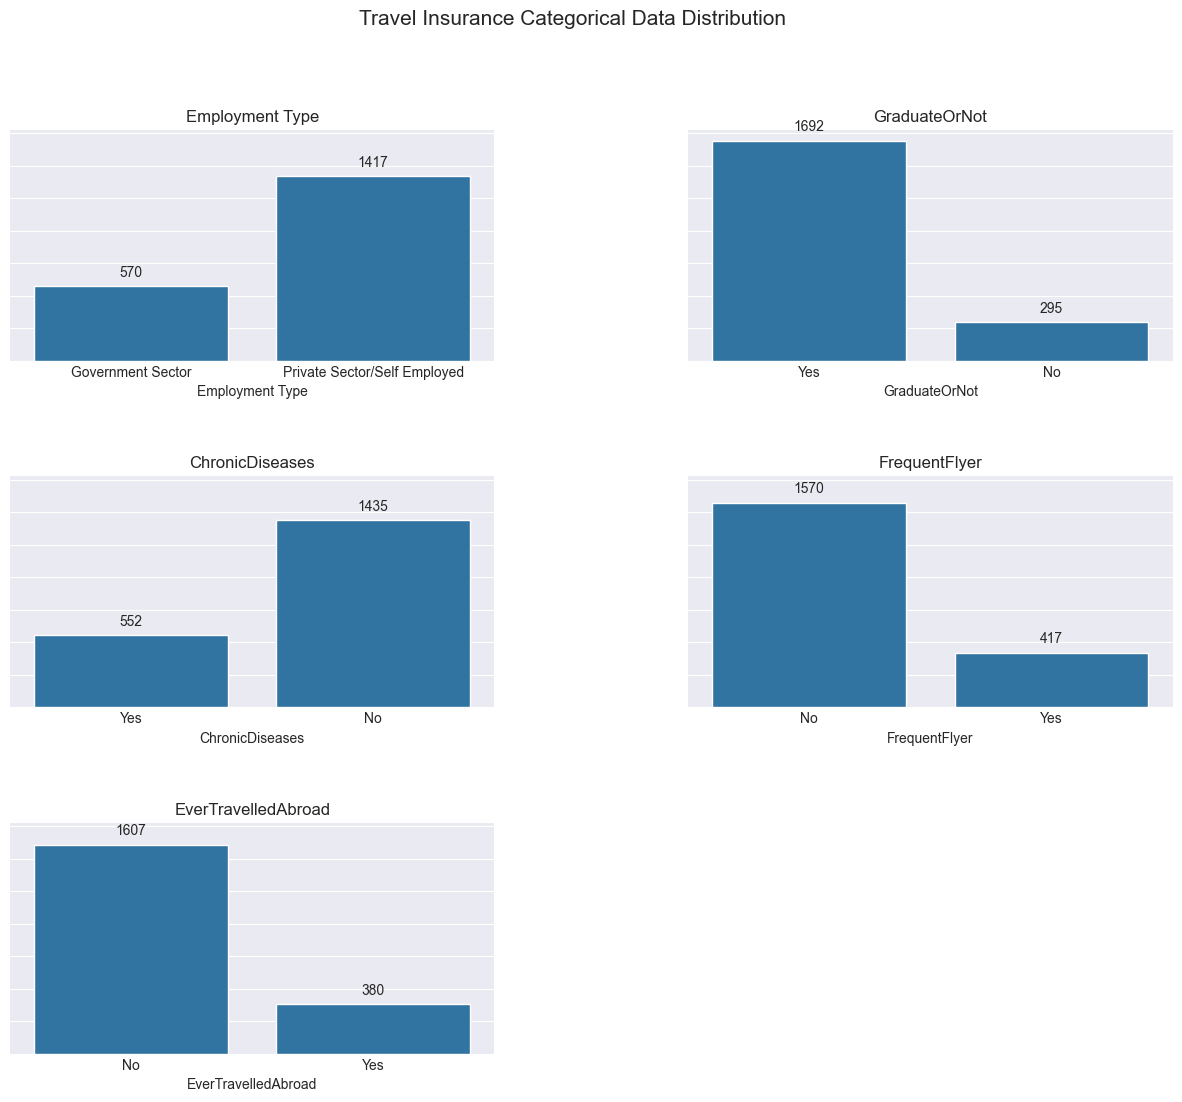

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12), sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.4)
axes_flatten = axes.flatten()

for i, col in enumerate(categorical_columns):
    sns.countplot(data=travelinsurance, x=col, ax=axes_flatten[i])
    axes_flatten[i].set_title(col) 
    for p in axes_flatten[i].patches:
        (axes_flatten[i]
         .annotate(f'{int(p.get_height())}',(p.get_x() + p.get_width() / 2., p
                                             .get_height()), ha='center', 
                   va='center', xytext=(0, 10), textcoords='offset points'))
    sns.despine(top=True, right=True, left=True, bottom=True)
    axes_flatten[i].tick_params(axis='x', which='both', length=0, labelbottom=True)
    axes_flatten[i].tick_params(axis='y', which='both', length=0, labelleft=False)
    axes_flatten[i].set(ylabel=None)
        
axes_flatten[5].clear()
axes_flatten[5].axis('off')

plt.suptitle('Travel Insurance Categorical Data Distribution', fontsize=15)
plt.show()

### 3. Label

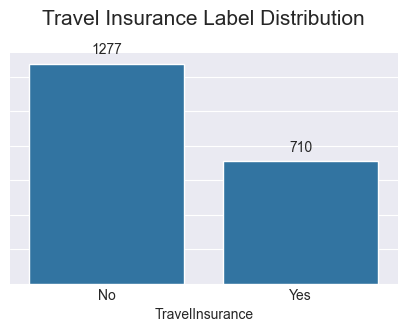

In [19]:
fig = plt.figure(figsize=(5, 3))
ax = sns.countplot(data=travelinsurance, x='TravelInsurance')
for p in ax.patches:
    (ax.annotate(f'{int(p.get_height())}',(p.get_x() + p.get_width() / 2., p
                                             .get_height()), ha='center', 
                   va='center', xytext=(0, 10), textcoords='offset points'))
    sns.despine(top=True, right=True, left=True, bottom=True)
    ax.tick_params(axis='x', which='both', length=0, labelbottom=True)
    ax.tick_params(axis='y', which='both', length=0, labelleft=False)
    ax.set(ylabel=None)
plt.title('Travel Insurance Label Distribution', fontsize=15, pad=20)
plt.show()

#### Summary

1. Categorical datas and label have a tendency in responses
2. Numerical datas are not heavily affected by outliers or skewness.
3. Family members is most normally distributed with an average at 5, mode at 4.
4. Annual Income seem to be divided into 2 subgroups.

## 2. Correlation

Objective:
1. Linear correlation within features
2. Linear correlation between features and label
3. Multicollinearity detection with VIF

### 1. Correlation with numerical features

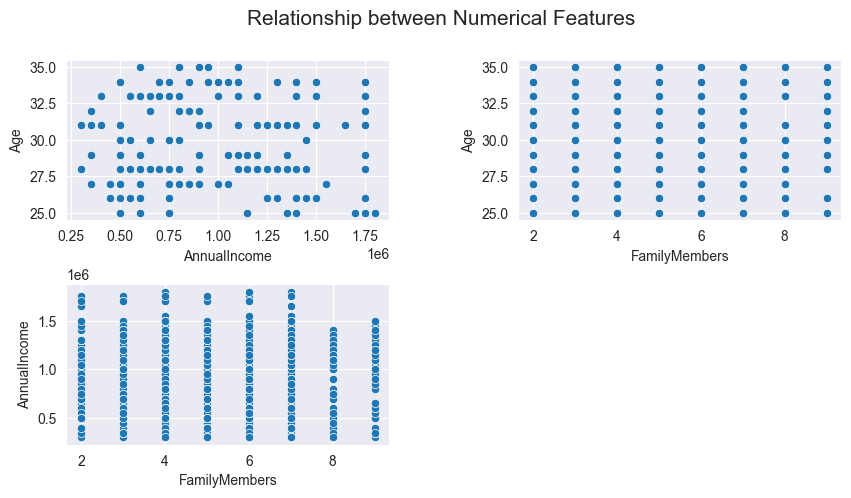

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

axes_flatten = axes.flatten()


sns.scatterplot(data=travelinsurance, x='AnnualIncome', y='Age', 
                ax=axes_flatten[0])
sns.scatterplot(data=travelinsurance, x='FamilyMembers', y='Age', 
                ax=axes_flatten[1])
sns.scatterplot(data=travelinsurance, x='FamilyMembers', y='AnnualIncome', 
                ax=axes_flatten[2])

axes_flatten[3].clear()
axes_flatten[3].axis('off')

fig.suptitle('Relationship between Numerical Features', fontsize=15)

plt.show()

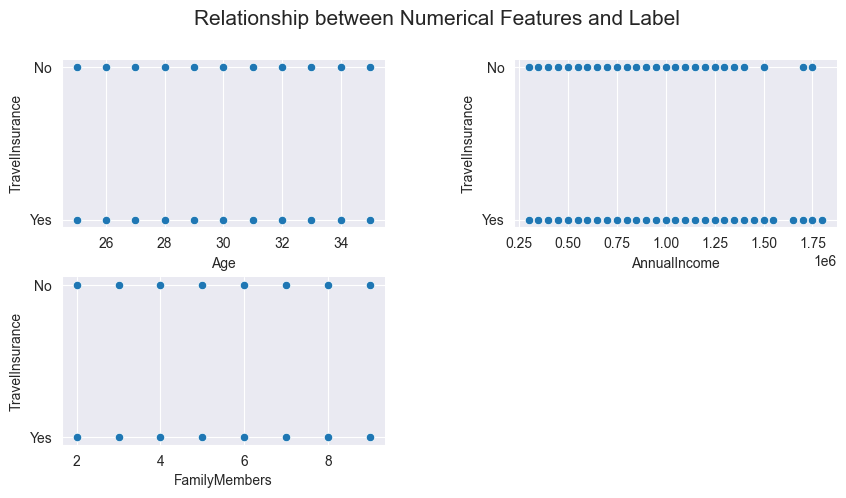

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
fig.subplots_adjust(hspace=0.3, wspace=0.4)

axes_flatten = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.scatterplot(x=col, y='TravelInsurance', data=travelinsurance, 
                    ax=axes_flatten[i])
    sns.despine(top=True, right=True, left=False, bottom=False)

axes_flatten[3].clear()
axes_flatten[3].axis('off')
fig.suptitle('Relationship between Numerical Features and Label', fontsize=15)

plt.show()

No further linear correlation calculations needed as correlation among 
<br >numeric
variables is not visually identifiable, meaning it is very weak.

### 2. Multicollinearity - Variance Inflation Factor

In [22]:
X = travelinsurance[numerical_columns]
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

         Feature        VIF
0            Age  14.132330
1   AnnualIncome   6.690676
2  FamilyMembers   9.130465


All columns have high multicollearity problems. <br>
Remove column 'Age' to see if the VIF values for other features reduce.

In [23]:
travelinsurance = travelinsurance.drop(columns=['Age'])
data = data.drop(columns=['Age'])
numerical_columns = ['AnnualIncome', 'FamilyMembers']

X = data[numerical_columns]
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

         Feature       VIF
0   AnnualIncome  4.311713
1  FamilyMembers  4.311713


Both features show moderate multicollinearity, these are usually acceptable 
<br>
values.

## 3. Statistic Inference

Objective: <br>
1. Define target population
2. Convert AnnualIncome into categorical data
3. Understand our target population by raising and testing multiple <br>
hypotheses and drop features irrelevant to target answer prediction.

### 1. Target Population

All Tour & Travel company's customers who might show interest in buying the 
<br>
Travel Insurance

### 2. Transform 'AnnualIncome'

This feature as shown previously in section 2, has a bimodal distribution. <br>
In order to state hypotheses focused on the difference between customers who
 <br> purchased and did not purchase the Travel Insurance in section 4, the 
 <br>
 features are ideally in the categorical data type.

In [24]:
mean = data['AnnualIncome'].mean()
data['AnnualIncome'] = (data['AnnualIncome']
                        .apply(lambda x: '<mean' if x < mean else '>mean'))

### 3. Hypothesis Testing

General Hypothesis: <br>
Is there evidence that customers who purchase the travel insurance has <br>
different characteristics than those who do not? <br>
<br>
Null hypothesis (H0): <br>
The characteristics of those who buy and who do not buy are the same. <br>
<br>
Alternative hypothesis (H1): <br>
There is a significant difference between customers who buy and who do not.

Note: the significance level considered is 0.05

**Chi-Square Tests** - 2 sided hypothesis test

In [25]:
p_values = []

for feature in data.columns:
    chi2_stat, p_val = chi2_test(travelinsurance, feature, 'TravelInsurance')
    p_values.append((feature, p_val))
    print(f'{feature} - chi2_statistic: {chi2_stat}, p-value: {p_val}')
    alpha = 0.05
    if p_val < alpha:
        print(f"Reject null hypothesis")
    else:
        print(f"Fail to reject null hypothesis")

Employment Type - chi2_statistic: 42.75380328896317, p-value: 6.208106601512192e-11
Reject null hypothesis
GraduateOrNot - chi2_statistic: 0.605510042905726, p-value: 0.4364833842842336
Fail to reject null hypothesis
AnnualIncome - chi2_statistic: 638.6459115549986, p-value: 6.055353915445171e-116
Reject null hypothesis
FamilyMembers - chi2_statistic: 29.11484324026023, p-value: 0.00013787342774603269
Reject null hypothesis
ChronicDiseases - chi2_statistic: 0.5754114650274649, p-value: 0.4481165216392011
Fail to reject null hypothesis
FrequentFlyer - chi2_statistic: 105.85723074203977, p-value: 7.924360415064537e-25
Reject null hypothesis
EverTravelledAbroad - chi2_statistic: 370.5599281861554, p-value: 1.4134505859999571e-82
Reject null hypothesis


Drop columns that do not show relevance to the target answer

In [26]:
travelinsurance = travelinsurance.drop(columns=['GraduateOrNot', 
                                                'ChronicDiseases'])
data = data.drop(columns=['GraduateOrNot', 'ChronicDiseases'])

# 3. Preprocessing

Objective: <br>
1. Scale numerical features to make sure all features have the same impact
2. Encode categorical data to numeric values, facilitating calculations.
3. Splitting data

## 1. Transformations

**Target**

In [27]:
Y = target.map({'Yes': 1, 'No': 0})
Y.head()

0    0
1    0
2    1
3    0
4    0
Name: TravelInsurance, dtype: int64

**Features** <br>
<br>
Yes: 1 <br>
No: 0 <br>

In [28]:
categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')
numerical_preprocessor = StandardScaler()

categorical_columns = categorical_columns_selector(data)
numerical_columns = ['FamilyMembers']

preprocessor = ColumnTransformer(
    [
        ("cat", categorical_preprocessor, categorical_columns),
        ("num", numerical_preprocessor, numerical_columns),
    ]
)
X = preprocessor.fit_transform(data)

## 2. Data Splitting 

Split data into train, validate and test sets.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, 
                                                    shuffle=True)

cv_result = cross_validate(model, data, target, cv=5)
scores = pd.DataFrame(cv_result['test_score'])
or 
scores = cv_result['test_score']
print('The mean cross-validation score is:', f'{scores.mean():.3f} +/- {scores.std():.3f}')
cv_result

# 4. Models

## 1. Apply various models

Logistic Regression

In [30]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_val)
print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred_log_reg))

Logistic Regression Accuracy: 0.7389937106918238


Random Forest

In [31]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_val)
print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))

Random Forest Accuracy: 0.7484276729559748


Support Vector Machine (SVM) 

In [32]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_val)
print("SVM Accuracy:", accuracy_score(y_val, y_pred_svm))

SVM Accuracy: 0.7484276729559748


Best Parameters - Grid Search

In [33]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", grid_search_rf.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}


In [34]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'linear']
}

grid_search_svm = GridSearchCV(estimator=SVC(), param_grid=param_grid_svm, cv=5, n_jobs=-1, verbose=2)
grid_search_svm.fit(X_train, y_train)
print("Best parameters for SVM:", grid_search_svm.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for SVM: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


## 2. Ensemble - Voting

In [35]:
voting_clf = VotingClassifier(estimators=[
    ('log_reg', log_reg),
    ('rf', grid_search_rf.best_estimator_),
    ('svm', grid_search_svm.best_estimator_)
], voting='hard')

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred_voting))

Voting Classifier Accuracy: 0.7889447236180904


# Improvements

1. Add different weights or remove duplicated instances to reduce 
overfitting <br> and bias in the model.
2. Check for correlation with label and numerical data using <br>
logistic regression, and with categorical data use Chi-Square tests.
3. Use Pipeline
4. Use Cross Validation to split data and to evaluate model performance